###### Татур А.А.
###### ДЗ_18 часть 2. Кластеризация текстов.
###### v0.1
###### 07.12.22
###### Данные - https://www.kaggle.com/competitions/nlp-getting-started/data . Набор представляет собой более 11000 твитов о каких-то катастрофах. Таргетная колонка имеет два значения (0 - нереальная катастрофа, 1-реальная катастрофа). Для простоты набор взят частично (первые 3000 строк)
###### Инструменты обработки - Векторизация -TF-IDF, Понижение размерности PCA, Embedding TSNE.

###### Цели
Из текстуальных данных с использованием алгоритмов кластеризации найти похожие.
В выводах обосновать какие метрики и алгоритмы лучше использовать для решения вышеизложенных задач.


###### Задачи

1. Загрузка текста
2. Токенизацию
3. Очистка текста (числа, знаки препинания, символы, стоп-слова)
4. Лемматизация
5. Получить обработанную версию текста
6. Выполнить кластеризацию текста различными методами.
7. Выводы

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift

from sklearn.metrics import silhouette_score, v_measure_score

#### 01. Определяем собственные функции

In [2]:
#функция для удаления эмодзи
def remove_emoji(string):
    import re
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [3]:
#обработка текста. Удаление мусорных слов, знаков препинания, приведение к нижнему регистру.
def text_preprocessing(text: str) ->str:
    
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    import string
    import re

    text=text.lower()#.replace(' \'s','')
    STOPWORDS  = stopwords.words('english')
    
      
    #Убираем эмоджи
    text = remove_emoji(text)
    
    #Убираем ссылки
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    
    #Убираем мусорные слова + лемматизация
    no_trash = [word for word in text.split(' ') if word not in STOPWORDS]
    no_trash = ' '.join(no_trash)
    
    #Вычленяем посимвольно знаки препинания и цифры
    no_punct_nodigits = [letter for letter in no_trash if letter not in string.punctuation 
                                                  and letter not in string.digits
                                                  and letter not in '“”']
    no_punct_nodigits = ''.join(no_punct_nodigits)
    
    
    #лемматизация
    lemmatizer = WordNetLemmatizer()
    one_lemma = [lemmatizer.lemmatize(word) for word in no_punct_nodigits]
    text=''.join(one_lemma)
    #после удаления апострофов появляются бесхозные буквы s и t
    
    text=text.replace(' s', '')
    text=text.replace(' t ','')
    
    return text

In [4]:
#Приводим все к векторному виду. на выход pd.DataFrame.
def vectorization(pdseries: pd.Series) ->pd.DataFrame:
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    vectorizer = TfidfVectorizer()
    corp_vect = vectorizer.fit_transform(pdseries)
    
    return pd.DataFrame (corp_vect.toarray(), columns = vectorizer.get_feature_names_out())

In [17]:
def measure(X, y, predict, n_clusters=None):
    '''
        Function for clusterization model assesement. On input takes:
        X - np.array with features
        y - np.array with lables
        n_clusters - number of clusters (default = None)
    '''
    if n_clusters:
        print (' For {} clusters'.format(n_clusters))
    print ('Silhouetter score is {}'.format (silhouette_score(X, predict)))
    print ('V_score is {}'.format (v_measure_score(y, predict)))

#### 02. Загружаем данные

In [5]:
df=pd.read_csv ('tweets.csv').drop (['id','location','keyword'],axis=1)
df=df.iloc[:1000]

In [6]:
df['text_preprocessing']=df.text.apply(text_preprocessing)

#### целевой параметр и свойства для обучения модельки
X=df.drop(['target','text'], axis=1)
y=df.target

#### 03. Векторизация, понижение размерности.

In [7]:
#Выполняем векторизацию
df_vectorized = vectorization(df.text_preprocessing)

In [8]:
df_vectorized.shape

(1000, 3847)

In [9]:
df_vectorized=df_vectorized.astype(np.uint8)

In [10]:
#Выполняем понижение размерности c сохранением 80% информации
model_PCA = PCA(0.8)
new_df_PCA = model_PCA.fit_transform(df_vectorized)

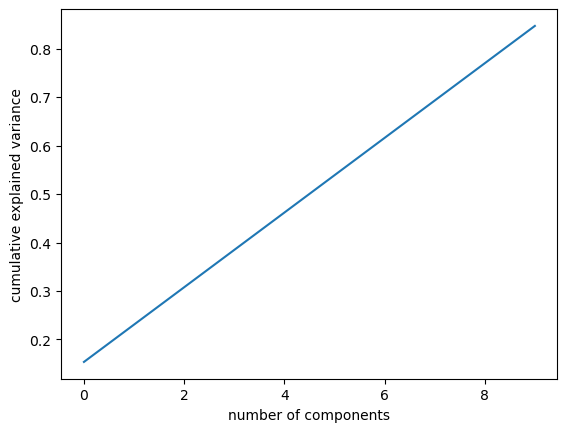

In [11]:
model_PCA.n_components_
plt.plot(np.cumsum(model_PCA.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [13]:
new_df_PCA_TSNE = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(new_df_PCA)

In [24]:
new_df_TSNE = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(df_vectorized)

### 04. Clusterization

#### 4.1. Кластеризация при помощи KMeans

In [20]:
kmeans=KMeans(n_clusters=2)

#### 4.1.1 KMeans on initial data

In [21]:
k_pred_init = kmeans.fit_predict(df_vectorized)
measure(df_vectorized,y,
       k_pred_init,
       n_clusters=kmeans.n_clusters)

 For 2 clusters
Silhouetter score is 0.9812998412002585
V_score is 0.002314860230184979


#### 4.1.1 KMeans after PCA

In [22]:
k_pred_PCA = kmeans.fit_predict(new_df_PCA)
measure(new_df_PCA,y,
       k_pred_PCA,
       n_clusters=kmeans.n_clusters)

 For 2 clusters
Silhouetter score is 0.9828052965745975
V_score is 0.002314860230184979


#### 4.1.1 KMeans after TSNE

In [25]:
k_pred_TSNE = kmeans.fit_predict(new_df_TSNE)
measure(new_df_TSNE,y,
       k_pred_TSNE,
       n_clusters=kmeans.n_clusters)

 For 2 clusters
Silhouetter score is 0.948013186454773
V_score is 0.004846952479969998


#### 4.1.1 KMeans after PCA_TSNE

In [26]:
k_pred_PCA_TSNE = kmeans.fit_predict(new_df_PCA_TSNE)
measure(new_df_PCA_TSNE,y,
       k_pred_PCA_TSNE,
       n_clusters=kmeans.n_clusters)

 For 2 clusters
Silhouetter score is 0.40477100014686584
V_score is 0.0286570424980365


#### 4.2. Кластеризация при помощи AgglomerativeClustering

In [28]:
aggl = AgglomerativeClustering(n_clusters=3)

#### 4.2.1 AgglomerativeClustering on initial data

In [29]:
aggl_pred_init = aggl.fit_predict(df_vectorized)
measure(df_vectorized,y,
       aggl_pred_init,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.9819928273792059
V_score is 0.0034312980601611805


#### 4.2.2 AgglomerativeClustering on data after PCA

In [30]:
aggl_pred_PCA = aggl.fit_predict(new_df_PCA)
measure(new_df_PCA,y,
       aggl_pred_PCA,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.98297690165017
V_score is 0.006009494267430447


#### 4.2.3 AgglomerativeClustering on data after TSNE

In [31]:
aggl_pred_TSNE = aggl.fit_predict(new_df_TSNE)
measure(new_df_TSNE,y,
       aggl_pred_TSNE,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.9834740161895752
V_score is 0.007263410500069263


#### 4.2.5 AgglomerativeClustering on data after TSNE+PCA

In [32]:
aggl_pred_PCA_TSNE = aggl.fit_predict(new_df_PCA_TSNE)
measure(new_df_PCA_TSNE,y,
       aggl_pred_PCA_TSNE,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.4248792231082916
V_score is 0.017351638513299798


##### Вывод:

Методы кластеризации показывают крайне низкий вариант предсказательной способности на продемонстрированном наборе текстов. Что вероятно может быть связано с плохой очисткой, а также неверным выбором feature extraction методов. В данной работе применен TfIDF, который учитывает лишь сам факт наличия слова в предложении, но ничего не может сказать о контексте в котором оно употреблено.